## Description

In this notebook we display the sum of the outgoing migrants / total population of the county per county over a given timespan 

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np


import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.collections import PatchCollection

from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon

from pysal.esda.mapclassify import Natural_Breaks as nb
from pysal.esda.mapclassify import Maximum_Breaks as mb
from pysal.esda.mapclassify import User_Defined

from descartes import PolygonPatch

import fiona
import stateplane
import pandas as pd
import itertools

from Data import *

# Load Data

Load data from IRS dataset

In [2]:
#%%timeit

startYear = 2008
stopYear = 2010

yearRange = range(startYear,stopYear+1)
populationDataFiles = [
    "data/output/population/%d_population_data.csv" % (i) for i in yearRange
]
migrationDataFiles = [
    "data/output/groundTruthOutput/%d_groundTruth_data.csv" % (i) for i in yearRange
]

populationDataSets = [loadPopulationFile(fn) for fn in populationDataFiles]
migrationDataSets = [loadMatrix(fn) for fn in migrationDataFiles]

#zero out the self migration values
for i in range(len(migrationDataSets)):
    for j in range(migrationDataSets[i].shape[0]):
        migrationDataSets[i][j,j] = 0

#load a list of county fips id's in sorted order
countyIds = loadCounties()

# Calculate the data we will be plotting

For each county we calculate the total number of outgoing migrants / total population of the county. We then show the difference 

In [3]:
# a list of dictionaries, one for each year, where they (key, value) pairs in 
# each dictionary represent (countyId, optimalC)
data = [
    {
        countyId:np.sum(migrationDataSets[i][j,:])/float(populationDataSets[i][j])
        for j,countyId in enumerate(countyIds)
    }
    for i in range(len(migrationDataSets))
]

# Calculate the range of the colorbar

Calculate the min and max values across all inputs in order to standardize the colorbar scale

In [4]:
colorBarMin,colorBarMax = float('inf'),float('-inf')
colorBarMinCounty,colorBarMaxCounty = 0,0
colorBarMinYear,colorBarMaxYear = 0,0

for i,d in enumerate(data):
    for k,v in d.items():
        if v>colorBarMax:
            colorBarMax = v
            colorBarMaxCounty = k
            colorBarMaxYear = yearRange[i]
        if v<colorBarMin:
            colorBarMin = v
            colorBarMinCounty = k
            colorBarMinYear = yearRange[i]
print "Minimum difference: %0.4f, FIPS of minimum difference: %d, Year of minimum difference: %d" % \
    (colorBarMin,colorBarMinCounty,colorBarMinYear)
print "Maximum difference: %0.4f, FIPS of maximum difference: %d, Year of maximum difference: %d" % \
    (colorBarMax,colorBarMaxCounty,colorBarMaxYear)

Minimum difference: 0.0000, FIPS of minimum difference: 41021, Year of minimum difference: 2008
Maximum difference: 0.1485, FIPS of maximum difference: 13053, Year of maximum difference: 2009


# Load county shapefile

In [5]:
shp = fiona.open("data/countyBoundaries/countyBoundaries2.shp")
bds = shp.bounds
shp.close()

ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(itertools.chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]

lat = (24.396308, 49.384358)
lon = (-124.848974, -66.885444)

# Plot the differences for each pair of years

Calculating the colormap for 2008


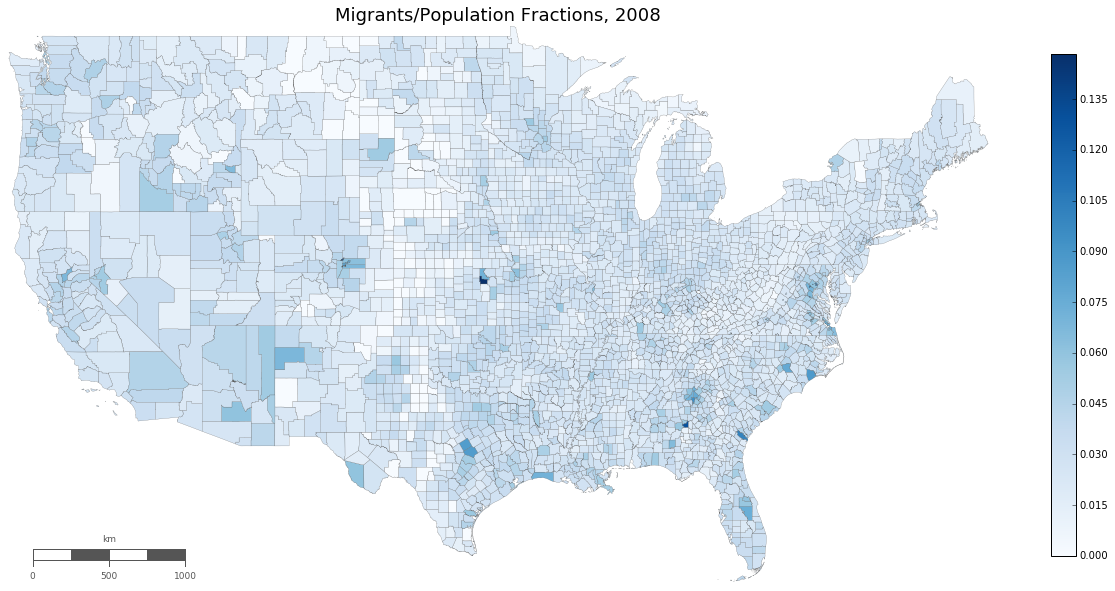

Calculating the colormap for 2009


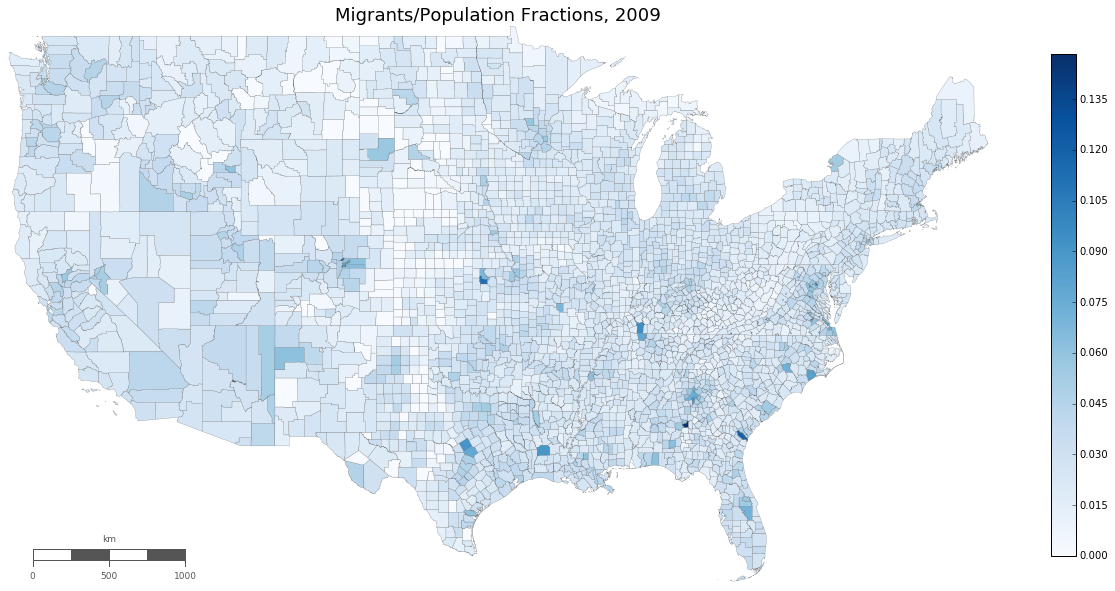

Calculating the colormap for 2010


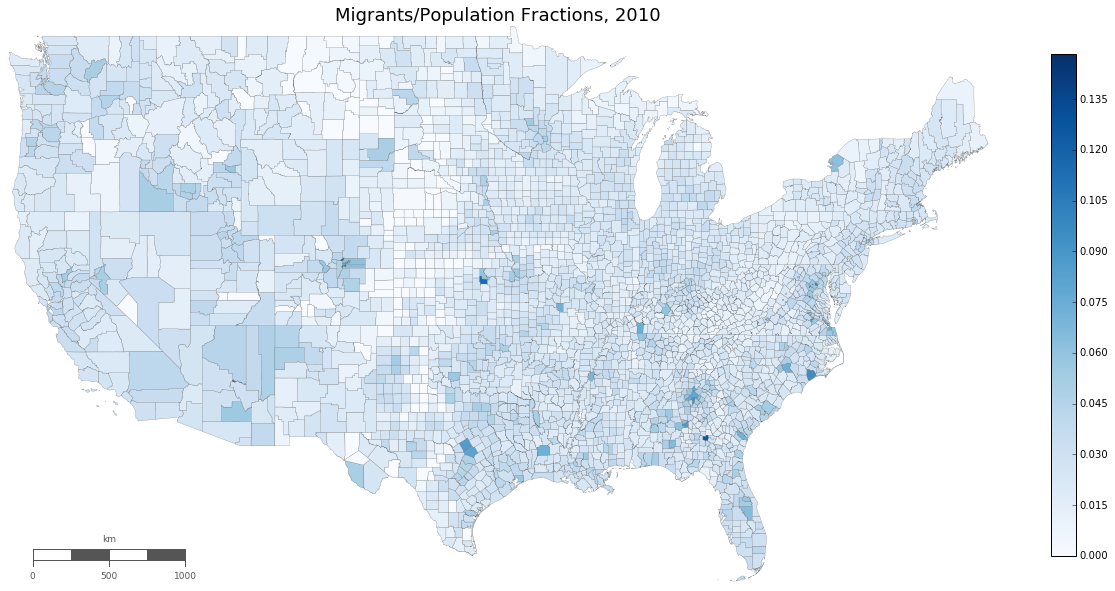

In [6]:
for i in range(len(yearRange)):
    year = yearRange[i]
    print "Calculating the colormap for %d" % (year)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, axisbg='#ffffff', frame_on=False)

    m = Basemap(
        projection='merc',
        llcrnrlat=lat[0],
        urcrnrlat=lat[1],
        llcrnrlon=lon[0],
        urcrnrlon=lon[1],
        resolution=None,
        fix_aspect=False,
        suppress_ticks=True
    )

    m.readshapefile(
        "data/countyBoundaries/countyBoundaries2",
        "dataInfo",
        drawbounds = False
    )


    polyList = []
    fipsList = []
    dataList = []
    for xy, info in zip(m.dataInfo,m.dataInfo_info):
        idVal = int(info["STATEFP"]+info["COUNTYFP"])
        if idVal in countyIds:
            fipsList.append(idVal)
            polyList.append(Polygon(xy))
            dataList.append(data[i][idVal])

    df_map = pd.DataFrame(
        {
        'poly': polyList,
        'cnt_fip': fipsList,
        'dataPoint': dataList
        }
    )
    
    df_map['area_m'] = df_map['poly'].map(lambda x: x.area)

    cmap = plt.get_cmap('Blues')

    df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(x, ec='#555555', lw=.2, alpha=1.0, zorder=4))

    pc = PatchCollection(df_map['patches'], match_original=True)
    
    norm = Normalize(vmin=colorBarMin, vmax=colorBarMax)
    faceColorValues = cmap(norm(df_map['dataPoint'].values))
    pc.set_facecolor(faceColorValues)
    ax.add_collection(pc)

    scalarMap = matplotlib.cm.ScalarMappable(cmap=cmap,norm=norm)
    scalarMap.set_clim(colorBarMin, colorBarMax)
    scalarMap.set_array(df_map['dataPoint'].values)

    colorBar = plt.colorbar(
        scalarMap,
        shrink=0.9,
        orientation='vertical',
        pad=0.05
    )

    m.drawmapscale(
        lon[0]+6, lat[0]+1.5, lon[0], lat[0],
        1000,
        barstyle='fancy',
        labelstyle='simple',
        fillcolor1='#ffffff',
        fillcolor2='#555555',
        fontcolor='#555555',
        zorder=5
    )

    m.drawmapboundary(
        color='k',
        linewidth=0.0,
        fill_color='#ffffff',
        zorder=None,
        ax=ax
    )

    plt.title(
        "Migrants/Population Fractions, %d" % (year),
        fontsize=18
    )

    fig.set_size_inches(22, 10)
    plt.savefig("outputs/c_map_%d.png" % (yearRange[i]), dpi=100, alpha=True)
    plt.show()

